### A Feed Forward Neural Net from Scratch

This is an implementation of a dense neural net from scratch. This will allow you to see the detail of creating and training a neural network. Here, we create a class called `neural_network` and we add it functions to handle forward pass, gradient descent, and error calculations.

The list `dimensions` specifies the number of neurons in each layer. For example `[2,3,2]` will create a network with 2 input neurons, 1 hidden layer with 3 neurons and 2 output neurons.

The `forward` function calculates activity of each of the neurons as a regression unit with *tanh* as the activation function. The output of the network will be a softmax which is a generalization of logistic regression when you have more than 1 output.

The `cur_error` function, calculates the inconsistency of our current output $\hat{y}$ with the true output $y$. Our error is  cross-entropy error function.

The `gradient_descent` function, calculates the derivative of the error with respect to the parameters `W` and `b` and store them in variables `dE_dW` and `dE_db`. Then it uses these derivatives to update the parameters to tune them for smaller error.

Finally, there is a function to handle visualization of the results. Note that this function can only visualize 2-dimensional input.

In [ ]:
#Homework 04

In [1]:
# Over fitting with noise=0.7, eta=0.001, lambda=0.1, n_samples=300, network with layers[2,8,8,8,2]

In [2]:
#####################################
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

In [3]:
# Neural Network Class
class neural_network(object):
    
    # initialize our network
    # dimensions are the sizes of the layers including the input and output layer
    def __init__(self, dimensions):
        '''
        Initialize the NN
        '''
        # number of layers
        self.num_layers = len(dimensions)
        # Initialize the parameters to random values
        np.random.seed(0)
        # create an empty list of weights
        self.W = [None]*(self.num_layers-1)
        # creat an empty list of biases
        self.b = [None]*(self.num_layers-1)
        # set the random values for the weights
        for i in range(self.num_layers-1):
            self.W[i] = np.random.randn(dimensions[i], dimensions[i+1])/np.sqrt(dimensions[i])
            self.b[i] = np.zeros((1, dimensions[i+1]))        
        
        # gradient descent stepsize 
        self.eta = 0.001
        # regularization coefficient
        self.reg_lambda = 0.00000001
    
    # forward propogate to predict an output (0 or 1)
    def forward(self, X):
        '''
        Feed forward the data to the NN
        X: the input to the NN
        The output is the predicted lable of the input.
        '''
        # input layer
        s_in = X.dot(self.W[0]) + self.b[0]
        a = np.tanh(s_in)
        # hidden layers
        for i in range(self.num_layers-3):
            # incoming signal
            s = a.dot(self.W[i+1]) + self.b[i+1]
            # activity
            a = np.tanh(s)
        # output layer
        s = a.dot(self.W[self.num_layers-2]) + self.b[self.num_layers-2]
        # softmax output values for probabilities
        exp_scores = np.exp(s)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # returning the value with the highest probability
        return np.argmax(probs, axis=1)
    
    # evaluate the total error on the current prediction
    def curr_error(self, X, y):
        '''
        Calculates the current error on the given data.
        X: the input to the NN
        y: the output to the NN. This should be an integer 
        number indicating the label of the corresponding input.
        '''
        y_hat = self.forward(X)
        incorr = np.ones(np.shape(y))
        for i in range(len(y)):
            if y_hat[i]==y[i]:
                incorr[i] = 0
        err = sum(incorr)/len(incorr)
        return err
    
    # batch gradient descent for minimizing the error
    def gradient_descent(self, X, y, num_passes = 100):
        N = len(y)
        s = [None]*(self.num_layers-1)
        a = [None]*(self.num_layers-2)
        for j in range(num_passes):
            # forward propagation
            s[0] = X.dot(self.W[0]) + self.b[0]
            a[0] = np.tanh(s[0])
            for i in range(self.num_layers-3):
                s[i+1] = a[i].dot(self.W[i+1]) + self.b[i+1]
                a[i+1] = np.tanh(s[i+1])
            s[self.num_layers-2] = (a[self.num_layers-3].dot(self.W[self.num_layers-2])
                                    +self.b[self.num_layers-2])
            exp_scores = np.exp(s[self.num_layers-2])
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            # backpropagating the error
            dE_dW = [None]*(self.num_layers-1)
            delta = [None]*(self.num_layers-1)
            dE_db = [None]*(self.num_layers-1)
            # output layer
            delta[self.num_layers-2] = probs
            delta[self.num_layers-2][range(N), y.astype(int)] -= 1
            dE_dW[self.num_layers-2] = (a[self.num_layers-3].T).dot(delta[self.num_layers-2])
            dE_db[self.num_layers-2] = np.sum(delta[self.num_layers-2], axis=0, keepdims=True)
            dE_dW[self.num_layers-2] += self.reg_lambda * self.W[self.num_layers-2]
            # hidden layers
            for i in range(self.num_layers-3):
                delta[self.num_layers-(3+i)] = (delta[self.num_layers-
                                                      (2+i)].dot(self.W[self.num_layers-(2+i)].T)*
                                                (1 - np.power(a[self.num_layers-(3+i)], 2)))
                dE_dW[self.num_layers-(3+i)] = np.dot(a[self.num_layers-(4+i)].T*\
                                                      (1 - np.power(a[self.num_layers-(3+i)], 2)).T,
                                                      delta[self.num_layers-(3+i)])
                dE_db[self.num_layers-(3+i)] = np.sum(delta[self.num_layers-(3+i)], axis=0)
                dE_dW[self.num_layers-(3+i)] += self.reg_lambda * self.W[self.num_layers-(3+i)]
            # input layer
            delta[0] = delta[1].dot(self.W[1].T) * (1 - np.power(a[0], 2))
            dE_dW[0] = np.dot(X.T, delta[0])
            dE_db[0] = np.sum(delta[0], axis=0)
            dE_dW[0] += self.reg_lambda * self.W[0]
            # update the weights
            for i in range(self.num_layers-1):
                self.W[i] += -self.eta * dE_dW[i]
                self.b[i] += -self.eta * dE_db[i]     
        return

In [4]:
# train and print the error
def error_over_iteration():
    num_Reports = 10
    for i in range(num_Reports):
        NN.gradient_descent(X,y,100)
        print(NN.curr_error(X,y))

In [5]:
# plot the decision boundary
def plot_decision_boundary():
    plt.clf()
    # set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # create a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid with current prediction
    Z = NN.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s =70)
    plt.show()
    return

### Working with Our Neural Net Class

The data should be in a specific form in order to feed it to our NN. 
- The input `X` should be a numpy array of the shape `(number of samples, dimension of each sample)`. Where the entries of the dimensions are normalized to have values between 0 and 1. 
- The output (label) `y` should be a numpy array of integers of the shape `(number of samples)` where each entry is an integer indicating the label of the corresponding input, i.e. `y[10]` should be the label of ```X[10]```.

Now lets make a new neural network object. You need to provide the dimensions of the network that you want to construct of the form:
```
NN = neural_network([dimension of the input, hidden layers dimensions, number of classes])
```

Note that the first entry is the dimension of the input `X` (i.e. number of the features) and it is not the number of the samples in your data.

- ```NN.forward(new_X)``` shows the prediction of the NN on the given input. Of course, without training, this prediction would be just random.
- ```NN.curr_error(new_X , new_y)``` shows the accuracy of the prediction on the given data.
- ```NN.gradient_descent(X_new , y_new , num_passes=100)``` train the weights of the NN on the given data by applying gradient descent 100 times.

In [6]:
# create a neural network with specified number of layers and units
NN = neural_network([2,8,8,8,2])

In [7]:
# import scikit-learn for creating a data set
import sklearn.datasets
X, y = sklearn.datasets.make_moons(n_samples=300, noise=0.7)
# X, y = sklearn.datasets.make_circles(n_samples=3000, factor=.5, noise=.08)

<IPython.core.display.Javascript object>


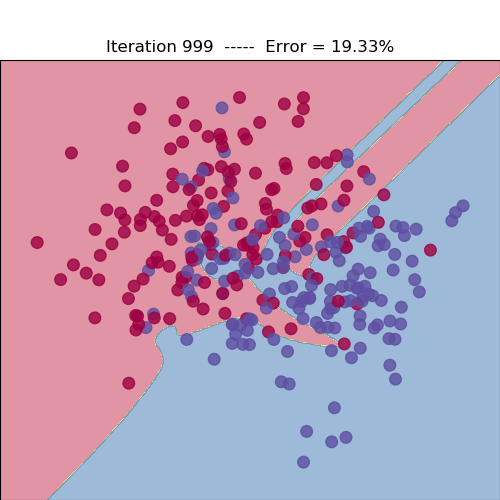

In [8]:
%matplotlib notebook
# set up a figure
fig, ax = plt.subplots(1, figsize=(5, 5), facecolor=(1,1,1))
fig.subplots_adjust(left=0, right=1, bottom=0)

# set min and max values and give it some padding
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
# create a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
# generate the frames for the movie
def animate(t):
    ax.clear()
    NN.gradient_descent(X,y,num_passes=5)
    Z = NN.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title('Iteration '+ str(t) + '  -----  '+ 'Error = ' + "{0:.2f}".format(NN.curr_error(X,y)*100)+'%')
    cont = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.5)
    scat = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s =70, alpha=0.8)
    return cont, scat

num_iterations = 1000
anim = animation.FuncAnimation(fig, animate, frames = num_iterations, repeat = False)

**Exercise (due date Wednesday 26/09).** Use sklearn to create two different types of data sets and use our neural net class to find the correct dicision boundaries. Use the visualizer to draw the diagram.

**Exercise (due date Wednesday 26/09).** The hyper-parameters of your model are the parameters that are not learned through training and usually are set/initialized when creating the network. For us, these parameters are the number of layers, number of nodes in each layer, the learning rate, and the regularization coefficient. Change the values of each of the hyper-parameters of the model ranging from extremely small numbers to large numbers. What will happen to training in those scenarios? Report your observations.

Backprop one loop:
```python
delta[k] = np.dot(delta[k+1],W[K+1].T)*(1-np.power(a[k],2))
dE_dW[k] = np.dot(a[k-1].T, delta[k])
```

In [ ]:
#under fitting eta=0.001, lambda=0.000001, network=[2,2,2,3], n_samples=100, factors=0.5, noise=0.08

In [15]:
# Neural Network Class
class neural_network(object):
    
    # initialize our network
    # dimensions are the sizes of the layers including the input and output layer
    def __init__(self, dimensions):
        '''
        Initialize the NN
        '''
        # number of layers
        self.num_layers = len(dimensions)
        # Initialize the parameters to random values
        np.random.seed(0)
        # create an empty list of weights
        self.W = [None]*(self.num_layers-1)
        # creat an empty list of biases
        self.b = [None]*(self.num_layers-1)
        # set the random values for the weights
        for i in range(self.num_layers-1):
            self.W[i] = np.random.randn(dimensions[i], dimensions[i+1])/np.sqrt(dimensions[i])
            self.b[i] = np.zeros((1, dimensions[i+1]))        
        
        # gradient descent stepsize 
        self.eta = 0.001
        # regularization coefficient
        self.reg_lambda = 0.000001
    
    # forward propogate to predict an output (0 or 1)
    def forward(self, X):
        '''
        Feed forward the data to the NN
        X: the input to the NN
        The output is the predicted lable of the input.
        '''
        # input layer
        s_in = X.dot(self.W[0]) + self.b[0]
        a = np.tanh(s_in)
        # hidden layers
        for i in range(self.num_layers-3):
            # incoming signal
            s = a.dot(self.W[i+1]) + self.b[i+1]
            # activity
            a = np.tanh(s)
        # output layer
        s = a.dot(self.W[self.num_layers-2]) + self.b[self.num_layers-2]
        # softmax output values for probabilities
        exp_scores = np.exp(s)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # returning the value with the highest probability
        return np.argmax(probs, axis=1)
    
    # evaluate the total error on the current prediction
    def curr_error(self, X, y):
        '''
        Calculates the current error on the given data.
        X: the input to the NN
        y: the output to the NN. This should be an integer 
        number indicating the label of the corresponding input.
        '''
        y_hat = self.forward(X)
        incorr = np.ones(np.shape(y))
        for i in range(len(y)):
            if y_hat[i]==y[i]:
                incorr[i] = 0
        err = sum(incorr)/len(incorr)
        return err
    
    # batch gradient descent for minimizing the error
    def gradient_descent(self, X, y, num_passes = 100):
        N = len(y)
        s = [None]*(self.num_layers-1)
        a = [None]*(self.num_layers-2)
        for j in range(num_passes):
            # forward propagation
            s[0] = X.dot(self.W[0]) + self.b[0]
            a[0] = np.tanh(s[0])
            for i in range(self.num_layers-3):
                s[i+1] = a[i].dot(self.W[i+1]) + self.b[i+1]
                a[i+1] = np.tanh(s[i+1])
            s[self.num_layers-2] = (a[self.num_layers-3].dot(self.W[self.num_layers-2])
                                    +self.b[self.num_layers-2])
            exp_scores = np.exp(s[self.num_layers-2])
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            # backpropagating the error
            dE_dW = [None]*(self.num_layers-1)
            delta = [None]*(self.num_layers-1)
            dE_db = [None]*(self.num_layers-1)
            # output layer
            delta[self.num_layers-2] = probs
            delta[self.num_layers-2][range(N), y.astype(int)] -= 1
            dE_dW[self.num_layers-2] = (a[self.num_layers-3].T).dot(delta[self.num_layers-2])
            dE_db[self.num_layers-2] = np.sum(delta[self.num_layers-2], axis=0, keepdims=True)
            dE_dW[self.num_layers-2] += self.reg_lambda * self.W[self.num_layers-2]
            # hidden layers
            for i in range(self.num_layers-3):
                delta[self.num_layers-(3+i)] = (delta[self.num_layers-
                                                      (2+i)].dot(self.W[self.num_layers-(2+i)].T)*
                                                (1 - np.power(a[self.num_layers-(3+i)], 2)))
                dE_dW[self.num_layers-(3+i)] = np.dot(a[self.num_layers-(4+i)].T*\
                                                      (1 - np.power(a[self.num_layers-(3+i)], 2)).T,
                                                      delta[self.num_layers-(3+i)])
                dE_db[self.num_layers-(3+i)] = np.sum(delta[self.num_layers-(3+i)], axis=0)
                dE_dW[self.num_layers-(3+i)] += self.reg_lambda * self.W[self.num_layers-(3+i)]
            # input layer
            delta[0] = delta[1].dot(self.W[1].T) * (1 - np.power(a[0], 2))
            dE_dW[0] = np.dot(X.T, delta[0])
            dE_db[0] = np.sum(delta[0], axis=0)
            dE_dW[0] += self.reg_lambda * self.W[0]
            # update the weights
            for i in range(self.num_layers-1):
                self.W[i] += -self.eta * dE_dW[i]
                self.b[i] += -self.eta * dE_db[i]     
        return

In [16]:
# train and print the error
def error_over_iteration():
    num_Reports = 10
    for i in range(num_Reports):
        NN.gradient_descent(X,y,100)
        print(NN.curr_error(X,y))

In [17]:
# plot the decision boundary
def plot_decision_boundary():
    plt.clf()
    # set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # create a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid with current prediction
    Z = NN.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s =70)
    plt.show()
    return

In [27]:
# create a neural network with specified number of layers and units
NN = neural_network([2,2,2,3])

In [28]:
# import scikit-learn for creating a data set
import sklearn.datasets
#X, y = sklearn.datasets.make_moons(n_samples=30000, noise=0.9)
X, y = sklearn.datasets.make_circles(n_samples=100, factor=0.5, noise=0.08)

<IPython.core.display.Javascript object>


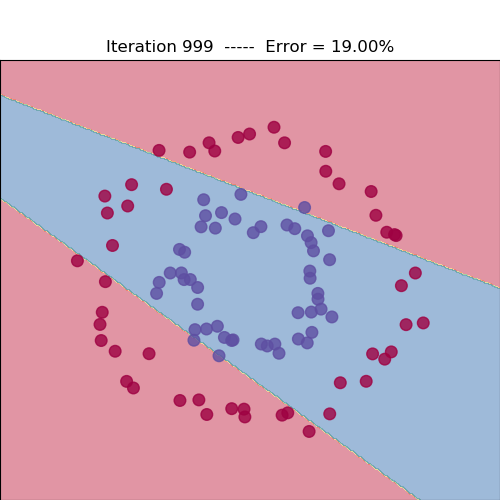

In [29]:
%matplotlib notebook
# set up a figure
fig, ax = plt.subplots(1, figsize=(5, 5), facecolor=(1,1,1))
fig.subplots_adjust(left=0, right=1, bottom=0)

# set min and max values and give it some padding
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
# create a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
# generate the frames for the movie
def animate(t):
    ax.clear()
    NN.gradient_descent(X,y,num_passes=5)
    Z = NN.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title('Iteration '+ str(t) + '  -----  '+ 'Error = ' + "{0:.2f}".format(NN.curr_error(X,y)*100)+'%')
    cont = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.5)
    scat = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s =70, alpha=0.8)
    return cont, scat

num_iterations = 1000
anim = animation.FuncAnimation(fig, animate, frames = num_iterations, repeat = False)